In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import math, os
from itertools import product
from multiprocessing import Pool
from functions import*
import itertools
import numpy as np

import time
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits import mplot3d
import copy
import pdb

In [12]:
def plt_random_nash(samples= 1000,j = 0,dim=10):
    rand_offers = np.random.rand(samples,3)
    my_rand_U = np.sum(np.array([1,2,3]) * rand_offers, axis=1)
    opp_rand_U = np.sum(np.array([3,2,1]) * (1-rand_offers), axis=1)

    plt_nash_space(my_rand_U, opp_rand_U,j,dim)
    ND = nash_distance(my_rand_U, opp_rand_U)
    PD = pareto_distance(my_rand_U, opp_rand_U)
    print("Average Distance from Nash Point: ", ND)
    print("Average Distance from Frontier: ", PD)
    print("Average Reward: ", my_rand_U.mean())
    print("Range: ", np.ptp(my_rand_U))

def load_net(c, discount, net_type, net_class):
    path = "c{}-d{}-play".format(c,discount)
    path = net_type + path
    Net = net_class()
    Net.load_state_dict(  torch.load(path+".th")  )
    return Net

def play_one_round(Net, c, discount):
    V = torch.Tensor([3,2,1])
    T = 20
    r = 0.0
    a = boulware(V,T,c,r)
    X1, P_res = boulware_actions(c)
    Net = Net
    t = 0
    accepted = False
    while not accepted and t <= 20:
        s = X1[t].unsqueeze(0)
        offer = Net.choose_action(s.unsqueeze(0))
        accepted = a.receive(offer,t)             
        t += 1

    t_final = t - 1
    if t == 21:
        final_reward = torch.Tensor([-0])
    else:
        final_reward = torch.sum(offer[:3] * Net.V) * discount**t_final
    
    return offer[:3].detach().numpy(), final_reward.detach().numpy(), t_final

In [13]:
def U_ego(offers):
    return np.sum(np.array([1,2,3]) * offers, axis=1)
def U_opp(offers):
    return np.sum(np.array([3,2,1]) * (offers), axis=1)

def Nash_solution(O):
    my_util  = O * torch.Tensor([1,2,3])
    opp_util = (1-O) * torch.Tensor([3,2,1])
    return my_util, opp_util

def calc_utils(O):
    my_util  = np.sum(O * np.array([1,2,3]))
    opp_util = np.sum((1-O) * np.array([3,2,1]))
    return my_util, opp_util

def plt_nash_space(Utils1, Utils2, j=5, dim=50, d=1.0,t=0.0):
    print(j)
    dim = dim
    xs = np.linspace(0,1,dim)
    ys = np.linspace(0,1,dim)
    zs = np.linspace(0,1,dim)
    my_U  = np.zeros(dim*dim*dim)
    opp_U = np.zeros(dim*dim*dim)
    os = np.zeros((dim*dim*dim,3))
    i = 0
    for x in xs:
        for y in ys:
            for z in zs:
                os[i] = np.array([x,y,z])
                my_U[i], opp_U[i] = calc_utils(np.array([x,y,z]))
                i += 1
    
    Nash_Sol = my_U * opp_U
#     plt.figure(figsize=(14,10))
    plt.scatter(my_U, opp_U,c = Nash_Sol) 
    if j ==5:
        plt.colorbar()
    plt.annotate("Nash Point", (4,4), fontsize = 15)
    plt.scatter(Utils1, Utils2,c="red",s=8)  
    if (j == 1) or (j == 2):
        plt.xlabel("My Utility", fontsize = 26)
    plt.ylabel("Opponent Utility", fontsize = 26)

def nash_distance(Utils1, Utils2):
    utils = np.vstack((Utils1, Utils2)).T
    nash_point = np.array([4,4])
    dif = nash_point - utils
    norm = np.linalg.norm(dif,axis = 1)
    return norm.mean()

def closest_dists(utils,a,b,c): # x and y a list of points, a b c the coefficients
    num = np.sum(utils*np.array([a,b]),axis = 1) + c
    return np.abs(num) / np.sqrt(a**2 + b**2)

def pareto_distance(my_rand_U, opp_rand_U):
    utils = np.vstack((my_rand_U, opp_rand_U)).T
    L1_dists = closest_dists(utils,(1/3),1,-6)
    L2_dists = closest_dists(utils,1,1,-8)
    L3_dists = closest_dists(utils,3,1,-18)
    P_dists  = np.vstack((L1_dists,L2_dists,L3_dists)).T
    P_dists  = np.min(P_dists,axis=1)
    return P_dists.mean()

def eval_net(c,d,Net,j,SAMPLES = 400,dim=10):
    start = time.time()
    offers = np.zeros((SAMPLES,3))
    rewards = np.zeros(SAMPLES)
    ts = np.zeros(SAMPLES)
    for i in range(SAMPLES):
        offers[i], rewards[i], ts[i] = play_one_round(Net,c,d)
    U_me, U_op = U_ego(offers), U_opp(1-offers)
    print(time.time() -start)
    
    plt_nash_space(U_me, U_op,j,dim)
    ND = nash_distance(U_me, U_op)
    PD = pareto_distance(U_me, U_op)
    print("#########", Net.name, "############")
    print("Average Distance from Nash Point: ", ND)
    print("Average Distance from Frontier: ", PD)
    print("Average Reward: ", rewards.mean())
    print("Average Play Time: ", ts.mean())
    print("Range: ", np.ptp(rewards))

0
Average Distance from Nash Point:  1.9303989079617287
Average Distance from Frontier:  1.248853215673526
Average Reward:  3.0199476742195994
Range:  5.414941603750254
12.812229871749878
0
######### NORMAL ############
Average Distance from Nash Point:  1.5827915203897214
Average Distance from Frontier:  0.08217795118999952
Average Reward:  4.991245884895324
Average Play Time:  11.018
Range:  0.294492244720459
25.657042026519775
1
######### BETA ############
Average Distance from Nash Point:  1.721849832973133
Average Distance from Frontier:  1.0481114319539684
Average Reward:  3.5604594492912294
Average Play Time:  17.974
Range:  5.378261566162109
15.032017946243286
2
######### CAUCHY ############
Average Distance from Nash Point:  2.318990953150609
Average Distance from Frontier:  0.1953531923427541
Average Reward:  5.097950694084168
Average Play Time:  14.752
Range:  4.403254747390747


Text(0.5, 1.0, 'Cauchy')

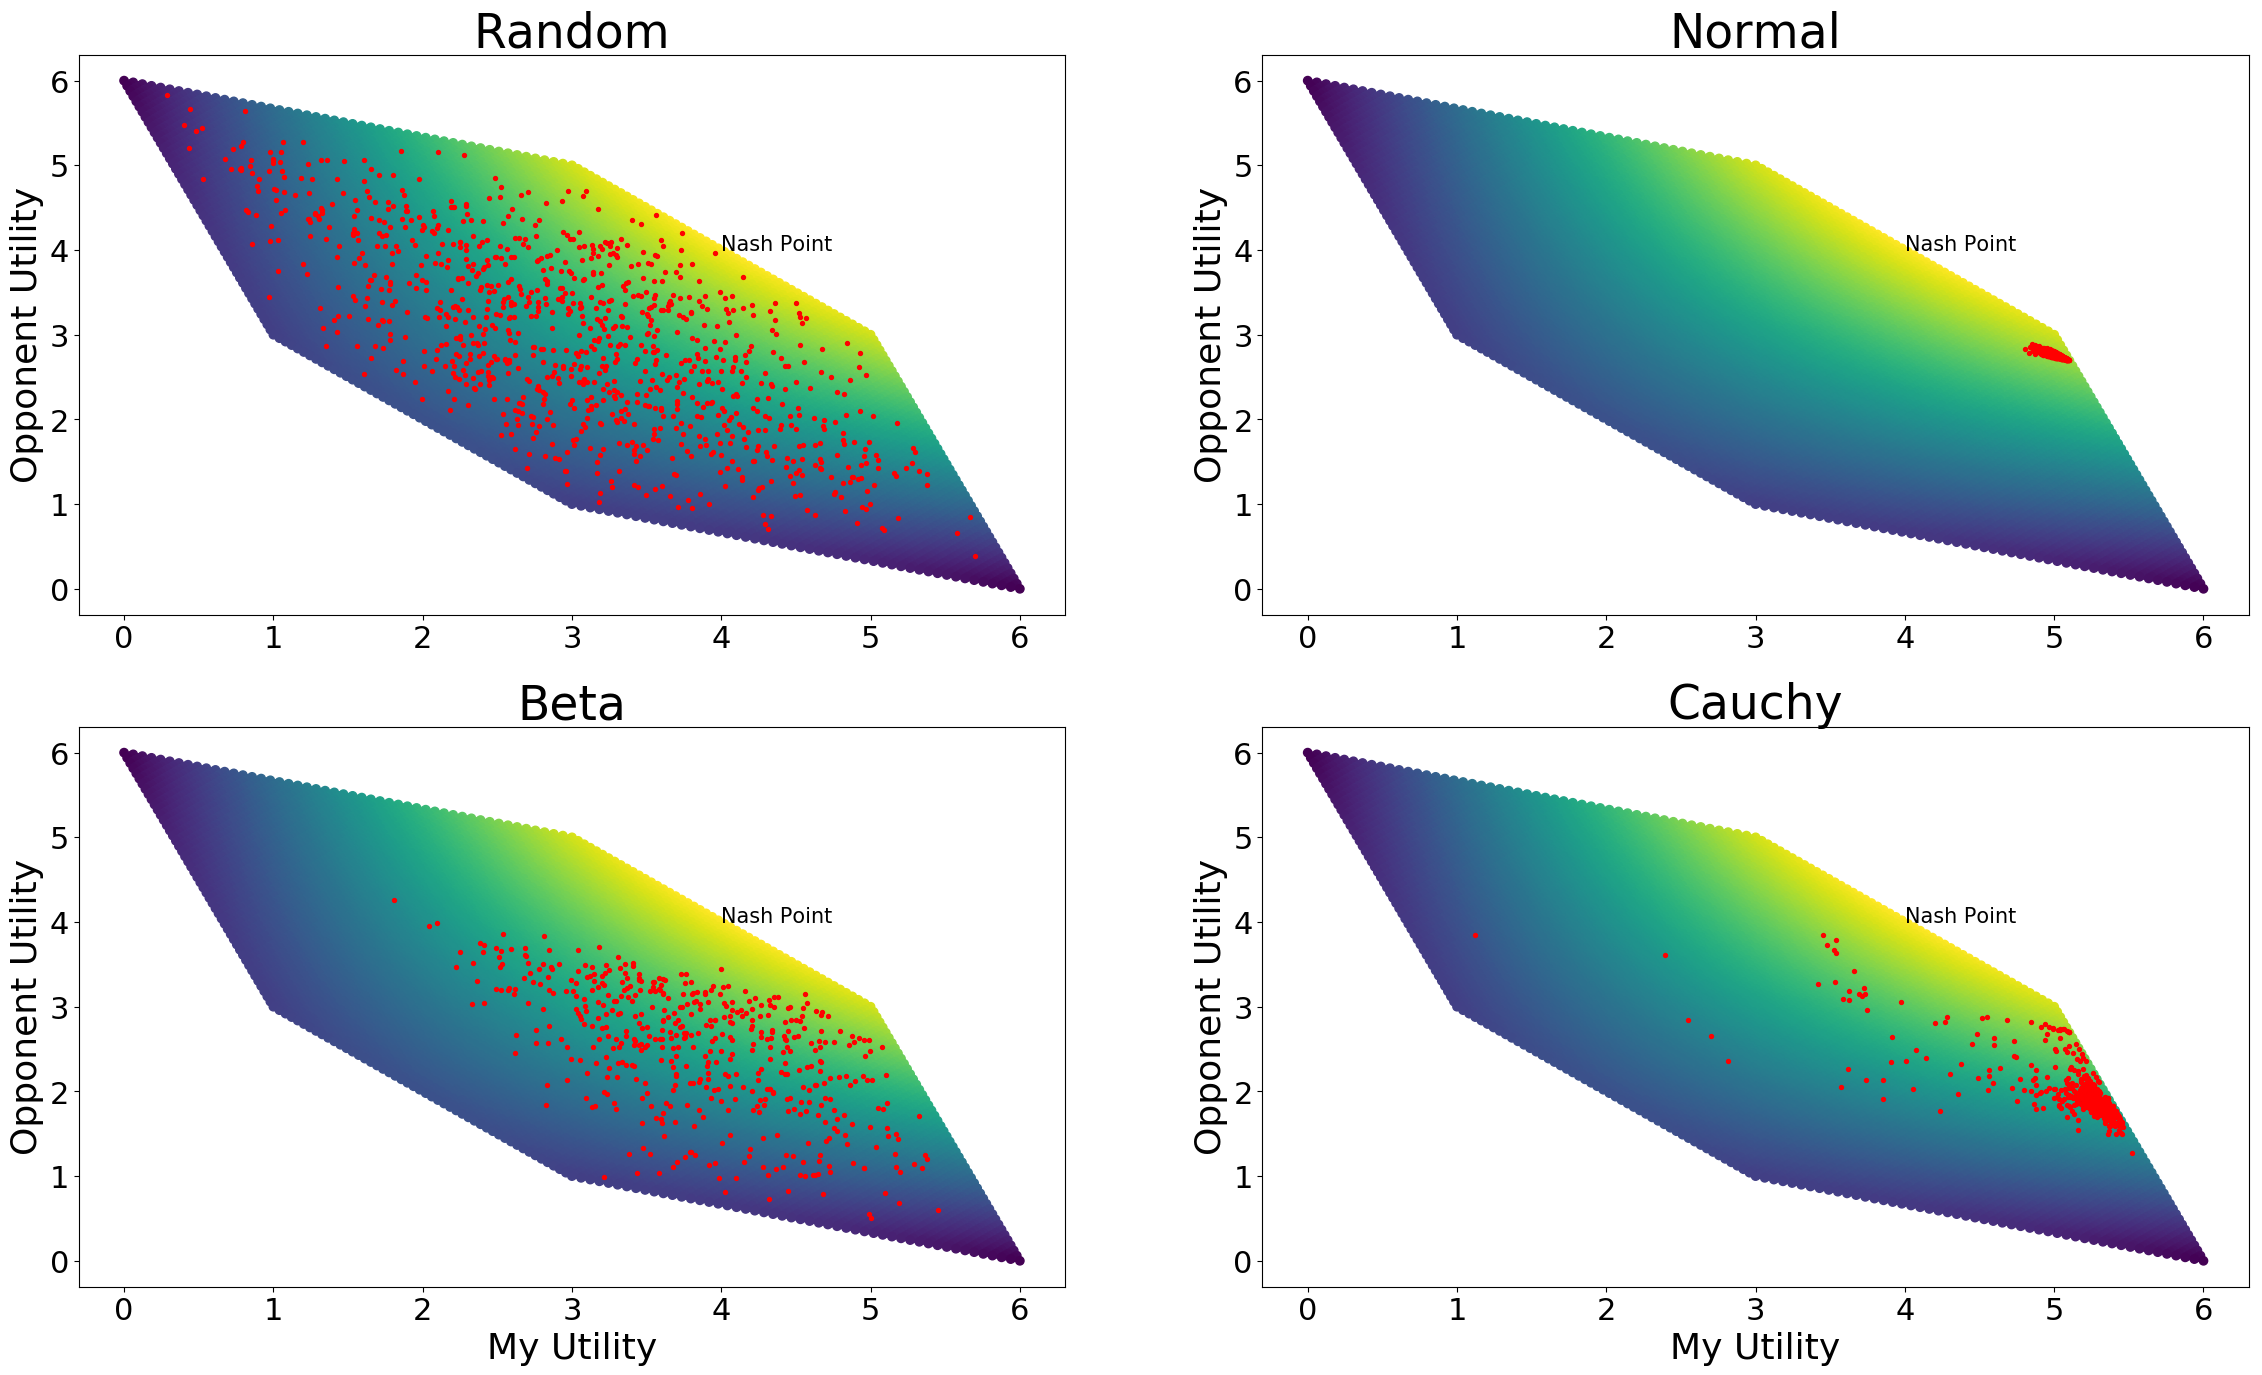

In [14]:
matplotlib.style.use("default")
plt.figure(figsize=(28,16))
DIM = 50
SAMPLES = 500
matplotlib.rc('xtick', labelsize=22) 
matplotlib.rc('ytick', labelsize=22)
plt.subplot(2,2,1)
plt_random_nash(dim=DIM)
plt.title("Random", fontsize = 34)

plt.subplot(2,2,2)
c, d = 1.0, 1.0
j = 0
Net = load_net(c,d, "Normal", ON_Normal)
eval_net(c,d,Net,j,SAMPLES = SAMPLES,dim=DIM)
plt.title("Normal", fontsize = 34)

plt.subplot(2,2,3)
c, d = 0.3, 1.0
# c, d = 1.0, 1.0
j = 1
Net = load_net(c,d, "Beta", ON_Beta)
eval_net(c,d,Net,j,SAMPLES = SAMPLES,dim=DIM)
plt.title("Beta", fontsize = 34)


plt.subplot(2,2,4)
c, d = 1.01, 1.0
j = 2
Net = load_net(c,d, "Cauchy", ON_Cauchy)
eval_net(c,d,Net,j,SAMPLES = SAMPLES,dim=DIM)
plt.title("Cauchy", fontsize = 34)
# plt.savefig("figures/offer_nash_outcomes.png")